# Example 12: Generating Standard f(z)

# Introduction

In this example, we calcuate $f_c(z)$ using main.evolve() without backreaction to generate what we call our _baseline f(z)_.  First, we demonstrate that our code is capable of matching previous results.  So we generate Fig. 22 of 1604.02457 by turning off some of the improvements introduced in DarkHistory.  Next, and finally, we turn back on the improvements introduced in DarkHistory and update Fig. 22 of 1604.02457, which will then give us $f_c(z,m_\chi)$, i.e. our baseline f(z).

In [1]:
%load_ext autoreload
import sys
sys.path.append("..")

In [2]:
%autoreload
import numpy as np

import matplotlib
matplotlib.rc_file('matplotlibrc')
import matplotlib.pyplot as plt

from astropy.io import fits

import numpy as np
import copy
import pickle
import darkhistory.spec.spectools as spectools
from tqdm import tqdm_notebook as tqdm
from scipy.interpolate import interp1d

import main

In [3]:
%matplotlib inline

## Comparison to 1604.02457

First we must set parameters to those used in 1604.02457

In [4]:
import darkhistory.physics as phys
phys.kB = 8.6173423e-5
phys.G = 6.6730e-8

kmperMpc = 3.08568025e19
amuperg = 6.0221415e23
eVperg = 5.60958921e32
nh0 = 0.022068*(1e2/kmperMpc)**2*amuperg*3/(8*np.pi*phys.G)

phys.omega_m       = 0.3175
phys.omega_rad     = 8e-5
phys.omega_lambda  = 0.6825
phys.omega_baryon  = 8*np.pi*phys.G/(3*phys.H0**2) * (nh0/amuperg)
phys.omega_DM      = phys.omega_m-phys.omega_baryon

phys.rho_DM=1274.4140

phys.nB = nh0
phys.rho_baryon = nh0*phys.mp

phys.YHe = .24

def TCMB(rs):
    fac = 2.725
    return fac * phys.kB * rs
phys.TCMB = TCMB

We will start by picking a DM mass making sure that we reproduce the correct f(z)'s for $\chi \to \gamma \gamma$ and $\chi \to e^+ e^-$. Then we will proceed to generate f(z)'s for decay, s-wave annihilation, and p-wave annihilation over a range of dark matter masses.

Either way, we're going to need the f(z)'s produced by IDL for the 1604.02457:

In [5]:
# Directory that contains all of the f(z)'s used in 1604.02457
user = '/Users/gregoryridgway'
direc = user+'/Dropbox (MIT)/Photon Deposition/idl_comparison/GR_Checks/ih_continuous_'

In [31]:
from astropy.io import fits
import darkhistory.spec.spectools as spectools

float_formatter = lambda x,n: ("{:."+str(n)+"E}").format(x,n)

# Input energy abscissa
log10eng0 = 3.6989700794219966
log10eng = np.array([log10eng0 + 0.23252559*i for i in np.arange(40)])
log10eng[-1] = 12.601505994846297

# List of f(z)'s used in 1604.02457
f_idl_list = np.zeros((2, len(log10eng),6398,5))
for k,inj_str in enumerate(['elec', 'phot']):
    if inj_str == 'elec':
        mass = phys.me
    else:
        mass = 0
        
    rs_list = [3000*np.exp(-0.001*i) for i in np.arange(6398)]
    for i, en in enumerate(log10eng[:-1]):
        hdul = fits.open(
            direc+inj_str+'/calcfracs_tf_z_3.000E+03_nstep_6398_logE_'
            +float_formatter(np.log10(10**en+mass), 3)+'_xe_0.000E+00.fits'
        )

        data = hdul[1].data

        f_idl_low  = data.field('loweng_deposition_fractions')[0]
        f_idl_high = data.field('higheng_deposition_fractions')[0]
        idl_redshift     = data.field('redshift')[0]

        f_idl_list[k,i,:] = np.swapaxes(f_idl_low + f_idl_high,0,1)

        hdul.close()

### IDL comparison for a single, fixed DM mass

First, $\chi \to \gamma \gamma$ with $m_\chi$ set to the 10th energy value.

In [14]:
%autoreload
mDM = 2*10**log10eng[10]
DH_run = main.evolve(
    primary='phot_delta',
    DM_process='decay', mDM=mDM, lifetime=3e25,
    start_rs = 3000, end_rs=4.02,
    coarsen_factor=4, backreaction=False, cross_check = True
)

In [15]:
single_DH_run_fs = np.array(
    [DH_run['f']['low'][channel]  + DH_run['f']['high'][channel] 
     for channel in ['H ion', 'He ion', 'exc', 'heat', 'cont']]
)

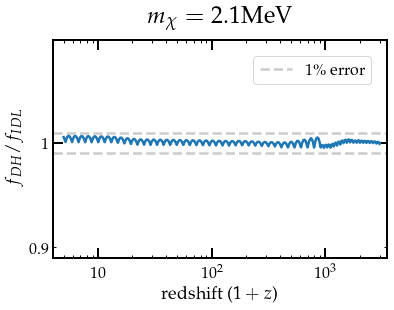

In [48]:
plt.figure()
ax = plt.gca()
ax.loglog()
plt.axis([4,3.5e3,.89,1.11])
line1 = plt.axhline(1 + .01,color='gray',linestyle='--',alpha=0.4, label='1\% error')
line2 = plt.axhline(1 - .01,color='gray',linestyle='--',alpha=0.4)
plt.plot(
    DH_run['rs'][:-54],
    (single_DH_run_fs[0,:-54]+1e-20)/(f_idl_list[1,10,::4,0]+1e-20)
)
plt.legend(handles=[line1])

plt.title(r'$m_\chi = 2.1$MeV')
plt.ylabel(r'$f_{DH}/f_{IDL}$')
plt.xlabel(r'redshift ($1+z$)')
plt.show()

## Generate files for physics.f_std()

First, we must set our parameters back to PLANCK 2018 parameters

In [6]:
phys.kB = 8.6173324e-5
phys.G = 6.6730e-8

phys.omega_m       = 0.3153
phys.omega_rad     = 8e-5
phys.omega_lambda  = 0.6847
phys.omega_baryon  = 0.02237/(phys.h**2)
phys.omega_DM      = 0.1200/(phys.h**2)

phys.rho_DM=phys.rho_crit*phys.omega_DM

phys.rho_baryon = phys.rho_crit*phys.omega_baryon
phys.nB = phys.rho_baryon/phys.mp

phys.YHe = 0.245

def TCMB(rs):
    fac = 2.7255
    return fac * kB * rs

phys.TCMB = TCMB

8.6173423e-05

# Specify Model

In [18]:
tau=.5e25

#Annihilation or decay?
inj_type = 'decay'

#Annihilate/Decay into
inj_particle = 'photon'

#Useful definitions
if inj_particle == 'electron':
    inj_str = 'elec'
    mass = phys.me
else:
    inj_str = 'phot'
    mass = 0

# Load IDL Files

Here we will download the data used in Fig. 22 of 1604.02457, dubbed the "IDL results" (since the code used to generate this data was written primarily in IDL).

### IDL parameters

Download the parameters used in the IDL files (file can be found at *erebus*@*lns.mit.edu:/zfs/gridgway/transferfuncs/ih_continuous_phot/tf_z_3.000E+03_nstep_6398_logE_1.021E+01_xe_0.000E+00.fits*)

In [19]:
# direc = cwd+'/../../ih_continuous_'+inj_str
user = '/Users/gregoryridgway'
direc = user+'/Dropbox (MIT)/Photon Deposition/idl_comparison/GR_Checks/ih_continuous_'

hdul = fits.open(direc+'elec/tf_z_3.000E+03_nstep_6398_logE_1.067E+01_xe_0.000E+00.fits')
direc = direc+inj_str
    
data = hdul[1].data

idl_photonspectrum = data.field('photonspectrum')[0]
idl_lowengphot = data.field('lowengphot')[0]
idl_lowengelec = data.field('lowengelec')[0]
idl_energy = data.field('energy')[0]
idl_eleceng = data.field('eleceng')[0]
idl_redshift = data.field('redshift')[0]
idl_cmblosstable = data.field('cmblosstable')[0]
idl_highengdep = data.field('highdeposited_grid')[0]

idl_bin_width = np.diff(np.log(spectools.get_bin_bound(data.field('energy')[0]))) * idl_energy
idl_elec_bin_width = np.diff(np.log(spectools.get_bin_bound(data.field('eleceng')[0]))) * idl_eleceng

xe_idl = data.field('hionfraction')[0]
xHe_idl = data.field('heionfraction')[0]

hdul.close()

xe_idl_func = interp1d(idl_redshift, xe_idl, bounds_error=False, fill_value=(xe_idl[-1], xe_idl[0]))
xHe_idl_func = interp1d(idl_redshift, xHe_idl, bounds_error=False, fill_value=(xHe_idl[-1], xHe_idl[0]))

The input energies used along the x-axis of Fig. 22 in 1604.02457

In [20]:
log10eng0 = 3.6989700794219966
log10eng = np.array([log10eng0 + 0.23252559*i for i in np.arange(40)])
log10eng[-1] = np.log10(idl_energy[-1])*.99

In [21]:
log10eng[-1]

12.601505994846297

### IDL f(z)'s

Download the f(z)'s generated from IDL (can be found in `erebus:/zfs/gridgway/transferfuncs/ih_continuous_elec_v2/` for electrons and `erebus:/zfs/gridgway/transferfuncs/ih_continuous_phot/` for photons)

In [22]:
float_formatter = lambda x,n: ("{:."+str(n)+"E}").format(x,n)

rs_list = [3000*np.exp(-0.001*i) for i in np.arange(6398)]
f_idl_list = np.zeros((len(log10eng),5,6398))
for i, en in enumerate(log10eng[:-1]):
    hdul = fits.open(
        direc+'/calcfracs_tf_z_3.000E+03_nstep_6398_logE_'
        +float_formatter(np.log10(10**en+mass), 3)+'_xe_0.000E+00.fits'
    )

    data = hdul[1].data

    f_idl_low  = data.field('loweng_deposition_fractions')[0]
    f_idl_high = data.field('higheng_deposition_fractions')[0]
    idl_redshift     = data.field('redshift')[0]

#     f_idl_list[i,:] = f_idl_low + f_idl_high
    f_idl_list[i,:] = f_idl_low

    hdul.close()

### Contour Plots

To prove that we have actually downloaded the correct data, we reproduce the contour plots below.  The discrepancies between these contour plots and those in Fig. 22 come from interpolation errors in Fig. 22 that aren't in the below.

In [23]:
def get_fcontour(f_input, inj_type, inj_particle, channel):
    f_for_plot = f_input.copy()
    eng = 10**log10eng
    coarsen_factor=round(6398/f_for_plot.shape[-1])

    ind = {'H_ion' : 0, 'He_ion' : 1, 'exc' : 2, 'heat' : 3, 'cont' : 4}[channel]
    if ind < 2:
        label = {'H_ion' : 'H_{ion}', 'He_ion' : 'He_{ion}'}[channel]
    else:
        label = channel
    title = r'\bf{$f_{'+label+'}$}'
    
    ax = plt.gca()
    ax.set_xscale('log')
    ax.set_yscale('log')

    plt.axis([eng[0], 10**log10eng[-1], 5, 2e3])

    levels = np.array([1e-5, 1e-4, 1e-3, 5e-3, 1e-2, 5e-2, 1e-1, 3e-1, 1e0])
    if inj_type is 'decay':
        if channel is 'He_ion':
            if inj_particle is 'phot':
                levels = np.array([1e-7, 1e-6, 1e-5, 1e-4, 5e-4, 1e-3, 5e-3, 1e-2, 4e-2])
            else:
                levels = np.array([1e-6, 1e-5, 5e-5, 1e-4, 5e-4, 1e-3, 5e-3, 1e-2, 4e-2])
        elif channel is 'exc':
            if inj_particle is 'phot':
                levels = np.array([1e-5, 1e-4, 1e-3, 5e-3, 1e-2, 3e-2, 5e-2, 1e-1, 1e-0])
            else:
                levels = np.array([1e-4, 1e-3, 5e-3, 1e-2, 3e-2, 5e-2, 1e-1, 2e-1, 7e-1])
        elif (channel is 'heat') or (channel is 'cont'):
            if inj_particle is 'elec':
                levels = np.array([1e-5, 1e-4, 1e-3, 1e-2, 5e-2, 1e-1, 3e-1, 5e-1, 1, 2])
    else:
        if inj_particle == 'phot':
            levels = np.array([1e-3, 1e-2, 1e-1, 2e-1, 5e-1, 1, 5, 10, 50, 200])
            if channel is 'He_ion':
                levels = np.array([1e-5, 1e-4, 1e-3, 5e-3, 1e-2, 5e-2, 1, 5, 10,100])
            elif channel is 'exc':
                levels = np.array([1e-3, 1e-2, 5e-2, 1e-1, 5e-1, 1, 5, 10, 100, 500])
            elif channel is 'heat':
                levels = np.array([1e-3, 1e-2, 2e-2, 5e-2, 1e-1, 2e-1, 5e-1, 1, 5, 10, 100])
            elif channel is 'cont':
                levels = np.array([1e-3, 1e-2, 2e-2, 5e-2, 1e-1, 5e-1, 1, 5, 10, 50, 500])
        elif inj_particle == 'elec':
            levels = np.array([1e-3, 1e-2, 1e-1, 2e-1, 1, 10, 100, 1000, 10000])
            if channel is 'He_ion':
                levels = np.array([1e-5, 1e-4, 1e-3, 2e-3, 1e-2, 1e-1, 10, 50, 1000])
            elif channel is 'exc':
                levels = np.array([1e-3, 1e-2, 5e-2, 1e-1, 2e-1, 1, 10, 100, 1000, 5000])
            elif channel is 'heat':
                levels = np.array([1e-3, 1e-2, 2e-2, 5e-2, 1e-1, 2e-1, 5e-1, 1, 10, 100, 1000, 10000])
            elif channel is 'cont':
                levels = np.array([1e-3, 1e-2, 2e-2, 5e-2, 1e-1, 5e-1, 1, 10, 100, 1000, 10000])
                
    f_for_plot[f_for_plot < levels[0]] = levels[0]*(1+.01)
    f_for_plot[f_for_plot > levels[-1]] = levels[-1]*(1-.01)
    
    levels2 = np.exp(np.linspace(np.log(levels[0]),np.log(levels[-1]),100))
    cs = ax.contourf(eng,idl_redshift[::coarsen_factor],
                     np.transpose(f_for_plot[:,ind]), 
#                      locator=matplotlib.ticker.LogLocator(), 
                     norm=matplotlib.colors.LogNorm(),
                     levels=levels2,
                     cmap=matplotlib.cm.inferno)
#                      cmap=matplotlib.cm.RdBu_r)
    ax.contour(eng,idl_redshift[::coarsen_factor],
               np.transpose(f_for_plot[:,ind]),  
               levels=levels[1:-1],
               colors='k',
               alpha=.4
              )

    cbar = plt.colorbar(cs, ticks=levels)
    cbar.ax.set_xticklabels(str(levels))

    plt.title(title)
    plt.ylabel(r'Redshift ($1+z$)')
    plt.xlabel(r'Kinetic Energy [eV]')
    
#     plt.savefig(
#         cwd+'/../../../f'+inj_particle+'_'+inj_type+'_'+channel+'_contour.png'
#     )
#     plt.savefig(
#         '/Users/gridgway/Dropbox (MIT)/Photon Deposition/Draft/plots/f_contour/f'+
#         inj_particle+'_'+inj_type+'_'+channel+'_contour.pdf'
#     )
    plt.show()

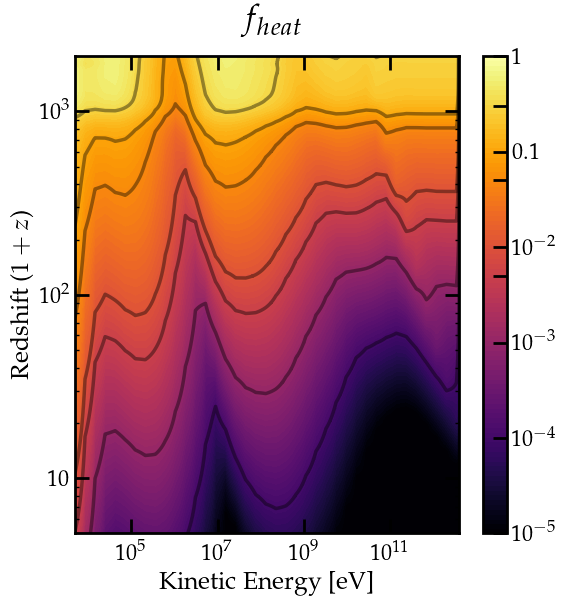

In [24]:
get_fcontour(f_idl_list, inj_type, inj_particle, 'heat')

In [12]:
def save_as_pickled_object(obj, filepath):
    """
    This is a defensive way to write pickle.write, allowing for very large files on all platforms
    """
    max_bytes = 2**31 - 1
    bytes_out = pickle.dumps(obj)
    n_bytes = sys.getsizeof(bytes_out)
    with open(filepath, 'wb') as f_out:
        for idx in range(0, n_bytes, max_bytes):
            f_out.write(bytes_out[idx:idx+max_bytes])

# Compute DH f(z)'s

Now we reproduce the above f(z)'s.  We compute the energy deposition history for 40 different DM masses, i.e. 40 different columns of the above plot, each DM mass corresponding to an $E_{inj}$ stored in `log10eng`.

(Description of Tracy's injection of 2+epsilon particles method)

(rate functions in the form of $\frac{\rho (z)}{m_DM}$ for example)

In [13]:
inj_type='swave'

In [14]:
if inj_type == 'decay':
    def struct_boost(rs):
        return 1
else:
    struct_boost = phys.struct_boost_func('einasto_with_subs')

In [182]:
%autoreload

tau=3e27
sigmav=3e-28
def get_column(i, f_DH_list, inj_particle='electron', inj_type='decay', end_rs=4.004):
    """ Produce one column of the f differential plot
    """
    #injection energy, DM mass, center-of-mass energy
    Einj = 10**log10eng[i]
    mDM = 2*Einj + 2*mass
    Ecom=mDM
    
    if inj_type == 'decay':
        def struct_boost(rs):
            return 1
    else:
        struct_boost = phys.struct_boost_func('einasto_with_subs')
    
    def rate_func_N(rs):
        return phys.inj_rate(inj_type, rs, mDM=mDM, sigmav=sigmav, tau=tau)*struct_boost(rs)/Ecom
    def rate_func_eng(rs):
        return phys.inj_rate(inj_type, rs, mDM=mDM, sigmav=sigmav, tau=tau)*struct_boost(rs)
    
    if inj_type == 'swave':
        mDM = mDM/2
        Ecom = 2*mDM   
    

    if inj_particle == 'photon':
        primary = 'phot_delta'
        coarsen_factor = 1
    else:
        primary = 'elec_delta'
        coarsen_factor = 1
    
    f_DH_list[i] = main.evolve(
        primary=primary,
        rate_func_N=rate_func_N, rate_func_eng=rate_func_eng,
        DM_process=inj_type, mDM=mDM, sigmav=sigmav, lifetime=tau,
        start_rs = 3000, end_rs=end_rs,
        coarsen_factor=coarsen_factor, backreaction=False,
        struct_boost=struct_boost
    )

In [184]:
%autoreload
inj_type='decay'
inj_particle='photon'
inj_str=inj_particle[:4]

if inj_particle == 'electron':
    mass = phys.me
else:
    mass = 0

# f_DH_data_phot = [None for i in np.arange(40)]
f_DH_data_phot = f_DH_data

for k in tqdm(np.arange(40)):
    if k<=2:
        print('starting run ', k)
        get_column(k, f_DH_data_phot, inj_particle=inj_particle, inj_type=inj_type, end_rs=4.004)

save_as_pickled_object(f_DH_data_phot, 
            '/Users/gregoryridgway/Dropbox (MIT)/Photon Deposition/idl_comparison/GR_Checks/ih_continuous_'
                       +inj_str+'/f_'+inj_str+'_'+inj_type+'_notCrossCheck.p'
                      )

starting run  0


starting run  1


-2.061793161926801


../darkhistory/physics.py:474: RuntimeWarning: invalid value encountered in double_scalars
  / (1 + 0.6703 * (conv_fac*T_m)**0.5300)


starting run  2


In [34]:
%autoreload
inj_type='swave'
inj_particle='photon'
inj_str=inj_particle[:4]

if inj_particle == 'electron':
    mass = phys.me
else:
    mass = 0

f_DH_data_swave = [None for i in np.arange(40)]

for k in tqdm(np.arange(40)):
    print('starting run ', k)
    get_column(k, f_DH_data_swave, inj_particle=inj_particle, inj_type=inj_type, end_rs=4.004)

save_as_pickled_object(f_DH_data_swave, 
            '/Users/gregoryridgway/Dropbox (MIT)/Photon Deposition/idl_comparison/GR_Checks/ih_continuous_'
                       +inj_str+'/f_'+inj_str+'_'+inj_type+'_notCrossCheck.p'
                      )

starting run  0


/usr/local/lib/python3.7/site-packages/scipy/integrate/odepack.py:247: ODEintWarning: Excess work done on this call (perhaps wrong Dfun type). Run with full_output = 1 to get quantitative information.
  warnings.warn(warning_msg, ODEintWarning)


-0.3756169055833291
-0.36166275791858954
-0.34080527946894407
-0.3234387040968649
-0.303617605675725
-0.284560607858641
-0.26398687644152063
-0.2457997085102515
-0.2229305848895251


../darkhistory/physics.py:474: RuntimeWarning: invalid value encountered in double_scalars
  / (1 + 0.6703 * (conv_fac*T_m)**0.5300)


-0.20855083503939098
-0.19250951299465735
-0.16732768586033375
-0.1496302803968097
-0.12386231389846009
-0.10611286313751161
-0.07998091957479203
-0.06164235941267693
-0.03412896740896715
-0.014001134608542798
starting run  1


-0.8864231266259034
-0.8494884904689939
-0.8071461284725922
-0.7704455068286407
-0.7371591851816546
-0.7034301794695138
-0.6715928986542522
-0.6398312475843808
-0.6087234854388786
-0.5785669286765396
-0.5488454315641109
-0.5208297968223281
-0.49214894679448645
-0.4650807996358287
-0.7577848543465342
-0.7337525330498148
-0.7068165030840872
-0.6814241099174543
-0.6556637214922763
-0.6305509080039713
-0.6053357921831577
-0.5812725796716955
-0.5560445275516137
-0.5339173199459673
-0.5116589033629826
-0.4869842767196973
-0.46480899270104703
-0.440291260518984
-0.4186788883070388
-0.3945430418045308
-0.37322398372536114
-0.3491431109310105
-0.32771896401684353
-0.3044085803086537
-0.28163485032734337
-0.25684310631181495
-0.23416938064044396
-0.20928435167241988
-0.18543119374620698
-0.16008841154414727
-0.13409144296594377
-0.10878224783589896
-0.07691048871070177
-0.04982839328650818
-0.02216300559685802
-0.11381651168896206
-0.09764963859539788
-0.08103119595422781
-0.056602934727750964
-

-0.4766788830774462
-0.46670726317956784
-0.45014786289037745
-0.4308177414836238
-0.41233571133860114
-0.39164179016734074
-0.3731585096363069
-0.35583899206766895
-0.3384371780053909
-0.3216316872062278
-0.3048782044107236
-0.28835265893108947
-0.27214358629501834
-0.2561033791266194
-0.24060241269461136
-0.22492159734231815
-0.2095697487470503
-0.3273156517494338
-0.3134395679495255
-0.29839748899690854
-0.28383135301941803
-0.2708265114637365
-0.2563781712818934
-0.24188590802375587
-0.22775477241183878
-0.21322005613104528
-0.19963782618056547
-0.18602830242978174
-0.17160682945948874
-0.15797653231800568
-0.14352225189681478
-0.1299819933461126
-0.11552947516442719
-0.10195973981858719
-0.0873637375817935
-0.07356595160389368
-0.05905564988452783
-0.04465501672291655
-0.02938505159604088
-0.014697838982220546
starting run  3


starting run  4


starting run  5


starting run  6


starting run  7


starting run  8


starting run  9


starting run  10


starting run  11


starting run  12


starting run  13


starting run  14


starting run  15


starting run  16


starting run  17


starting run  18


starting run  19


starting run  20


starting run  21


starting run  22


starting run  23


starting run  24


starting run  25


starting run  26


starting run  27


starting run  28


-2.7298975804354404
starting run  29


starting run  30


-2.3099379685347943
starting run  31


starting run  32


starting run  33


starting run  34


starting run  35


starting run  36


-0.865167100911268
starting run  37


-2.4390509902393998
starting run  38


starting run  39


In [34]:
save_as_pickled_object(f_DH_data, 
            '/Users/gregoryridgway/Dropbox (MIT)/Photon Deposition/idl_comparison/GR_Checks/ih_continuous_'
                       +inj_str+'/f_'+inj_str+'_'+inj_type+'_notCrossCheck.p'
                      )

In [33]:
%autoreload
inj_type='decay'
inj_particle='electron'
inj_str=inj_particle[:4]

if inj_particle == 'electron':
    mass = phys.me
else:
    mass = 0

# f_DH_data = [None for i in np.arange(40)]

for k in tqdm(np.arange(40)):
    print('starting run ', k)
    if k>25:
        get_column(k, f_DH_data, inj_particle=inj_particle, inj_type=inj_type, end_rs=4.004)

save_as_pickled_object(f_DH_data, 
            '/Users/gregoryridgway/Dropbox (MIT)/Photon Deposition/idl_comparison/GR_Checks/ih_continuous_'
                       +inj_str+'/f_'+inj_str+'_'+inj_type+'_notCrossCheck.p'
                      )

starting run  0
starting run  1
starting run  2
starting run  3
starting run  4
starting run  5
starting run  6
starting run  7
starting run  8
starting run  9
starting run  10
starting run  11
starting run  12
starting run  13
starting run  14
starting run  15
starting run  16
starting run  17
starting run  18
starting run  19
starting run  20
starting run  21
starting run  22
starting run  23
starting run  24
starting run  25
starting run  26


-2.184934949968797


../darkhistory/physics.py:474: RuntimeWarning: invalid value encountered in double_scalars
  / (1 + 0.6703 * (conv_fac*T_m)**0.5300)


starting run  27


starting run  28


starting run  29


starting run  30


-0.3346771178583301
starting run  31


-0.6626375639347085
starting run  32


starting run  33


starting run  34


starting run  35


starting run  36


starting run  37


starting run  38


starting run  39


FileNotFoundError: [Errno 2] No such file or directory: '/Users/gridgway/Dropbox (MIT)/Photon Deposition/idl_comparison/GR_Checks/ih_continuous_elec/f_elec_decay_notCrossCheck.p'

In [26]:
f_DH_data = pickle.load(open('/Users/gregoryridgway/Dropbox (MIT)/Photon Deposition/idl_comparison/GR_Checks/ih_continuous_'
    +'elec/f_elec_swave_notCrossCheck_noStructure.p','rb'))

In [27]:
f_DH_data_struct = pickle.load(open('/Users/gregoryridgway/Dropbox (MIT)/Photon Deposition/idl_comparison/GR_Checks/ih_continuous_'
    +'elec/f_elec_swave_notCrossCheck.p','rb'))

In [28]:
f_DH_data_struct[0]['Tm']/f_DH_data[0]['Tm']-1

array([0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
       0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
       0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
       0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
       0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
       0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
       0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
       0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
       0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
       0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
       0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
       0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
       0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
       0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
      

In [85]:
f_DH_data_elec_swave

[{'rs': array([3000.        , 2997.0014995 , 2994.005996  , ...,    4.01231173,
            4.00830143,    4.00429513]),
  'x': array([[9.99999999e-01, 7.88595679e-02],
         [9.99999999e-01, 7.88565876e-02],
         [9.99999999e-01, 7.88535031e-02],
         ...,
         [4.52189796e-01, 5.43939893e-14],
         [4.52736280e-01, 5.43939893e-14],
         [4.53283512e-01, 5.43939893e-14]]),
  'Tm': array([0.70446773, 0.70389208, 0.70318879, ..., 1.52245674, 1.52474551,
         1.52703841]),
  'highengphot': <darkhistory.spec.spectra.Spectra at 0x1425ee128>,
  'lowengphot': <darkhistory.spec.spectra.Spectra at 0x1425ee6d8>,
  'lowengelec': <darkhistory.spec.spectra.Spectra at 0x1425ee588>,
  'f': {'low': {'H ion': array([5.72442258e-07, 1.77035195e-06, 4.89962894e-03, ...,
           2.08136726e+02, 2.08777587e+02, 2.09420473e+02]),
    'He ion': array([5.72442290e-07, 7.45621265e-07, 1.05735333e-06, ...,
           1.31572352e+01, 1.31987565e+01, 1.32404111e+01]),
    'exc': arr

In [16]:
%autoreload
inj_type='swave'
inj_particle='electron'
inj_str=inj_particle[:4]

if inj_particle == 'electron':
    mass = phys.me
else:
    mass = 0

# f_DH_data_elec_swave = [None for i in np.arange(40)]

for k in tqdm(np.arange(40)):
    print('starting run ', k)
    get_column(k, f_DH_data_elec_swave, inj_particle=inj_particle, inj_type=inj_type, end_rs=4.004)

save_as_pickled_object(f_DH_data_elec_swave, 
            '/Users/gregoryridgway/Dropbox (MIT)/Photon Deposition/idl_comparison/GR_Checks/ih_continuous_'
                       +inj_str+'/f_'+inj_str+'_'+inj_type+'_notCrossCheck.p'
                      )

starting run  0
****** Loading transfer functions... ******
    for propagating photons...   Done!
    for low-energy photons...  Done!
    for low-energy electrons...  Done!
    for high-energy deposition...  Done!
    for total upscattered CMB energy rate...  Done!
****** Loading complete! ******
****** Loading transfer functions... ******
    for inverse Compton (Thomson)...  Done!
    for inverse Compton (relativistic)...  Done!
    for inverse Compton (energy loss)...  Done!
****** Loading complete! ******


starting run  1


starting run  2


starting run  3


starting run  4


starting run  5


starting run  6


starting run  7


starting run  8


starting run  9


starting run  10


starting run  11


starting run  12


starting run  13


starting run  14


starting run  15


starting run  16


starting run  17


starting run  18


starting run  19


starting run  20


starting run  21


starting run  22


starting run  23


starting run  24


starting run  25


starting run  26


-0.6689104579772408


../darkhistory/physics.py:474: RuntimeWarning: invalid value encountered in double_scalars
  / (1 + 0.6703 * (conv_fac*T_m)**0.5300)


starting run  27


-1.460107021637443
starting run  28


starting run  29


-0.8699667380327608
starting run  30


starting run  31


starting run  32


starting run  33


-0.8976599866249477
starting run  34


starting run  35


-0.9799885923793588
starting run  36


starting run  37


starting run  38


starting run  39


-2.1970180002618163



In [23]:
%autoreload
inj_type='swave'
inj_particle='electron'
inj_str=inj_particle[:4]

if inj_particle == 'electron':
    mass = phys.me
else:
    mass = 0

f_DH_data = [None for i in np.arange(40)]

for k in tqdm(np.arange(40)):
    print('starting run ', k)
    get_column(k, f_DH_data, inj_particle=inj_particle, inj_type=inj_type, end_rs=4.996)

save_as_pickled_object(f_DH_data, 
            '/Users/gridgway/Dropbox (MIT)/Photon Deposition/idl_comparison/GR_Checks/ih_continuous_'
                       +inj_str+'/f_'+inj_str+'_'+inj_type+'_notCrossCheck_noStructure.p'
                      )

starting run  0


starting run  1


starting run  2


starting run  3


starting run  4


starting run  5


starting run  6


starting run  7


starting run  8


starting run  9


starting run  10


/Users/gridgway/anaconda3/lib/python3.6/site-packages/scipy/integrate/odepack.py:247: ODEintWarning: Excess work done on this call (perhaps wrong Dfun type). Run with full_output = 1 to get quantitative information.
  warnings.warn(warning_msg, ODEintWarning)


starting run  11


starting run  12


starting run  13


starting run  14


starting run  15


starting run  16


starting run  17


starting run  18


starting run  19


starting run  20


starting run  21


starting run  22


starting run  23


starting run  24


starting run  25


starting run  26


starting run  27


starting run  28


starting run  29


starting run  30


starting run  31


starting run  32


starting run  33


starting run  34


starting run  35


starting run  36


starting run  37


starting run  38


starting run  39


In [24]:
%autoreload
inj_type='swave'
inj_particle='photon'
inj_str=inj_particle[:4]

if inj_particle == 'electron':
    mass = phys.me
else:
    mass = 0

f_DH_data = [None for i in np.arange(40)]

for k in tqdm(np.arange(40)):
    print('starting run ', k)
    get_column(k, f_DH_data, inj_particle=inj_particle, inj_type=inj_type, end_rs=4.996)

save_as_pickled_object(f_DH_data, 
            '/Users/gridgway/Dropbox (MIT)/Photon Deposition/idl_comparison/GR_Checks/ih_continuous_'
                       +inj_str+'/i'
                      )

starting run  0


/Users/gridgway/anaconda3/lib/python3.6/site-packages/scipy/integrate/odepack.py:247: ODEintWarning: Excess work done on this call (perhaps wrong Dfun type). Run with full_output = 1 to get quantitative information.
  warnings.warn(warning_msg, ODEintWarning)


-1.9455977357027125
-1.6804485371256939
-1.4153758186231815
-1.173754620386002

../darkhistory/physics.py:474: RuntimeWarning: invalid value encountered in double_scalars
  / (1 + 0.6703 * (conv_fac*T_m)**0.5300)



-3.2634218799301524
-5.338048118827688
-5.0305951281999075
-4.724133559291612
-4.404748832896881
-4.088245205626101
-3.7989359302319436
-3.445106834873785
-3.081333368937636
-2.6986802139450594
-2.3070524556084706
-1.8426208741604824
-1.347459404257622
-0.8055798876150244
-0.19809806306616934
-1.6230307768606675
-1.315860367150362
-0.8035528578216007
-0.6264702734223373
-0.372803079637929
-0.009841223895708961
starting run  1


-5.125296872408427
-5.5115071610873665
-5.750020134825308
-0.013004660366007281
-5.341101047039056
-4.96343807856112
-4.622430312281341
-5.263056830868226
-5.222849917313416
-5.489388281538435
-0.00070818003645573
-5.38954861062777
-5.1721120329242805
-4.995690539935081
-4.855285087302814
-4.721333004891942
-4.615345688469044
-4.539425259287814
-4.49479107542115
-4.439605984616291
-4.050121290993311
-3.647565463077426
-3.2243085248778227
-2.7363230512953627
-2.3477640379732096
-3.3061358534310843
-3.047909094920048
-2.7211427980089526
-2.508354252774504
-2.2771578357687057
-2.0137507659871567
-1.7459996725407003
-0.8836689619862199
-0.4612728647242887
-0.12245722922436353
-0.08923324021620826
-1.0658475589295524
-0.806795255613675
-0.5366050435346674
-0.2621830887282182
starting run  2


-3.44879674434746
-3.0248592560346195
-2.795142728185613
-2.5872057195073355
-2.39657722186966
-2.2185840579263325
-2.021607243017447
-1.8689605062503427
-1.9723701143975052
-2.0830732404218995
-1.9509122225825826
-1.8268042419850183
-1.7101996542814872
-1.6017785401455087
-1.5016068457053922
-1.404343544164739
-1.3124118915407337
-1.2248787846030489
-1.141161969058445
-1.0571068555132523
-0.9738253994554672
-0.8890037620889756
-0.7992878936039128
-0.6930791024070719
-0.5998128412286368
-0.794497678265352
-0.6718174865653282
-0.5674428046080033
-0.49746028455838665
-0.43088705472493066
-0.35973409189935757
-0.2863664775190821
-0.07299618668148383
-0.19609391040329816
-0.07753708197967646
starting run  3


-0.9823539615942032
-0.6302941899285976
-0.5565792615511556
-0.4888442966487487
-0.4214295313806378
-0.3608358854123119
-0.3041507623628676
-0.25071129280446436
-0.20058952022725107
-0.2420717064432269
-0.28360332174185926
-0.23727796935248102
-0.196076822533493
-0.15617408572485003
-0.1126389298342807
-0.07276206403928887
-0.033628513923069425
starting run  4


starting run  5


starting run  6


starting run  7


starting run  8


starting run  9


starting run  10


starting run  11


starting run  12


starting run  13


starting run  14


starting run  15


starting run  16


starting run  17


starting run  18


starting run  19


starting run  20


starting run  21


starting run  22


starting run  23


starting run  24


starting run  25


starting run  26


starting run  27


starting run  28


starting run  29


starting run  30


starting run  31


starting run  32


starting run  33


starting run  34


starting run  35


starting run  36


starting run  37


starting run  38


starting run  39


# Plot

In [154]:
inj_particle='photon'
inj_str=inj_particle[:4]
inj_type='swave'
struct = True
if struct:
    extra = ''
else:
    extra = '_noStructure'
    
if inj_particle == 'photon':
    coarsen_factor = 2
else:
    coarsen_factor = 8

In [155]:
f_DH_data = pickle.load(open('/Users/gregoryridgway/Dropbox (MIT)/Photon Deposition/idl_comparison/GR_Checks/ih_continuous_'
                       +inj_str+'/f_'+inj_str+'_'+inj_type+'_notCrossCheck'+extra+'.p','rb')
                      )

In [157]:
f_DH_list = np.ones((40,5,round(6398/coarsen_factor)))*1e-6
for k in np.arange(40):
    f_DH_list[k] = np.array(
    [np.flipud(f_DH_data[k]['f']['low']['H ion']),
     np.flipud(f_DH_data[k]['f']['low']['He ion']),
     np.flipud(f_DH_data[k]['f']['low']['exc']),
     np.flipud(f_DH_data[k]['f']['low']['heat']),
     np.flipud(f_DH_data[k]['f']['low']['cont'])]
)

f_DH_list = np.swapaxes(f_DH_list,1,2)
f_DH_list[f_DH_list<=0] = 1e-12

In [158]:
if struct:
    pickle.dump(f_DH_list,open('/Users/gregoryridgway/Dropbox (MIT)/Photon Deposition/DarkHistory_data/f_'+
                               inj_str+'_'+inj_type+'_std_einasto_subs.p','wb'))
else:
    pickle.dump(f_DH_list,open('/Users/gregoryridgway/Dropbox (MIT)/Photon Deposition/DarkHistory_data/f_'+
                               inj_str+'_'+inj_type+'_std.p','wb'))

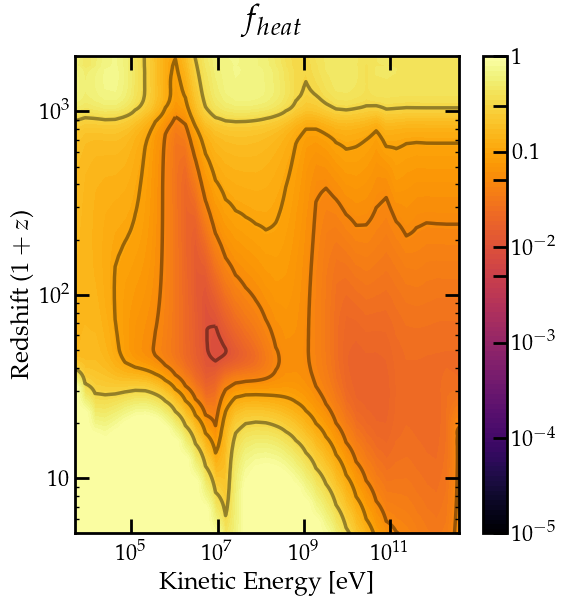

In [102]:
# f_DH_tmp = np.swapaxes(f_DH_list[:,0],1,2)
get_fcontour(f_DH_list, inj_type, inj_str, 'heat')

In [140]:
f_DH_list.shape

(40, 5, 3199)

In [143]:
np.log(idl_redshift)

array([8.00636757, 8.00536757, 8.00436757, ..., 1.61136757, 1.61036757,
       1.60936757])

In [145]:
from scipy.interpolate import RegularGridInterpolator

In [17]:
f_DH_list = np.ones((40,5,round(6398/coarsen_factor)))*1e-6
for k in np.arange(40):
    f_DH_list[k] = np.array(
    [np.flipud(f_DH_data[k]['f']['low']['H ion']),
     np.flipud(f_DH_data[k]['f']['low']['He ion']),
     np.flipud(f_DH_data[k]['f']['low']['exc']),
     np.flipud(f_DH_data[k]['f']['low']['heat']),
     np.flipud(f_DH_data[k]['f']['low']['cont'])]
)
f_DH_list = np.swapaxes(f_DH_list, 1, 2)
f_DH_list[f_DH_list<=0] = 1e-12

NameError: name 'coarsen_factor' is not defined

In [161]:
func = RegularGridInterpolator((log10eng, np.flipud(np.log(idl_redshift[::2]))), np.log(f_DH_list))

/Users/gridgway/anaconda3/lib/python3.6/site-packages/matplotlib/font_manager.py:1328: UserWarning: findfont: Font family ['serif'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))


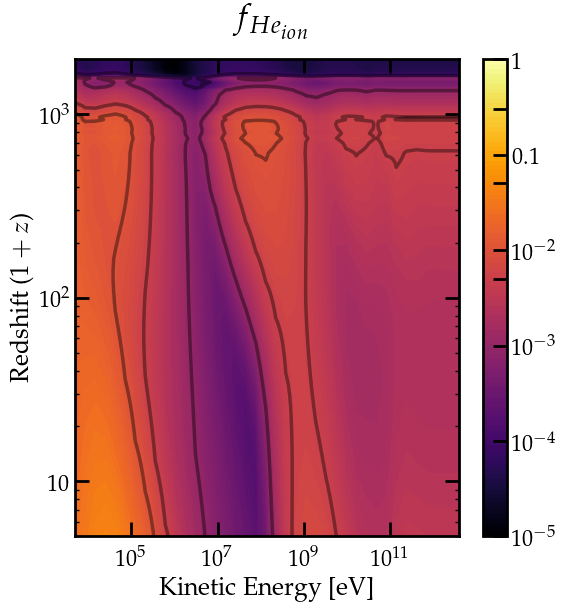

In [129]:
get_fcontour(f_DH_list, inj_type, inj_particle, 'He_ion')

/Users/gridgway/anaconda3/lib/python3.6/site-packages/matplotlib/font_manager.py:1328: UserWarning: findfont: Font family ['serif'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))


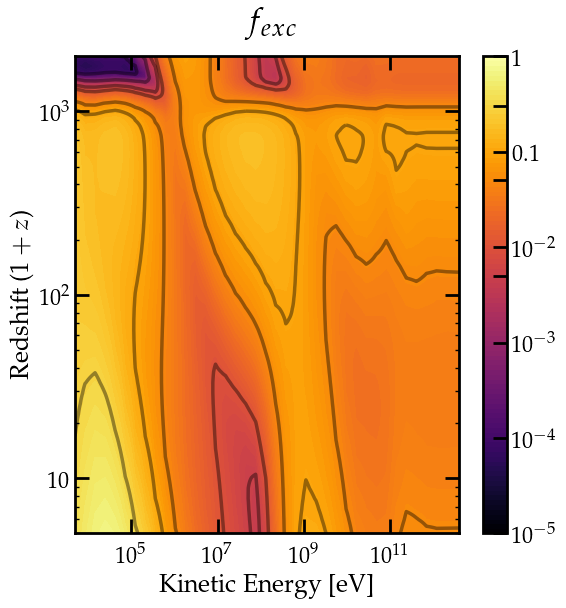

In [130]:
get_fcontour(f_DH_list, inj_type, inj_particle, 'exc')

/Users/gridgway/anaconda3/lib/python3.6/site-packages/matplotlib/font_manager.py:1328: UserWarning: findfont: Font family ['serif'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))


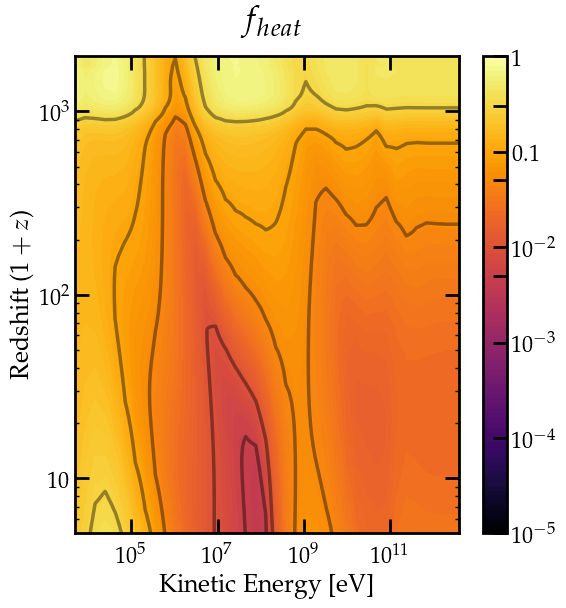

In [131]:
get_fcontour(f_DH_list, inj_type, inj_particle, 'heat')

# Plot f contours

To see the level of discrepancy between the two data sets, is useful to plot the absolute residual difference between the two sets of f(z)'s.  We will find that we do better than 10% accuracy for essentially all of the data.

In [300]:
inj_particle='elec'
inj_str=inj_particle[:4]
inj_type='swave'
struct = True
if struct:
    extra = ''
else:
    extra = '_noStructure'
    
if inj_particle == 'photon':
    coarsen_factor = 1
else:
    coarsen_factor = 1
    
f_DH_data = pickle.load(open('/Users/gregoryridgway/Dropbox (MIT)/Photon Deposition/idl_comparison/GR_Checks/ih_continuous_'
                   +inj_str+'/f_'+inj_str+'_'+inj_type+'_notCrossCheck'+extra+'.p','rb')
                  )

In [301]:
f_DH_list = np.ones((40,5,round(6620)))*1e-6
tmp=1
for k in np.arange(40):
    f_DH_list[k] = np.array(
    [np.flipud(f_DH_data[k]['f']['low']['H ion']+tmp*f_DH_data[k]['f']['high']['H ion']),
     np.flipud(f_DH_data[k]['f']['low']['He ion']+tmp*f_DH_data[k]['f']['high']['He ion']),
     np.flipud(f_DH_data[k]['f']['low']['exc']+tmp*f_DH_data[k]['f']['high']['exc']),
     np.flipud(f_DH_data[k]['f']['low']['heat']+tmp*f_DH_data[k]['f']['high']['heat']),
     np.flipud(f_DH_data[k]['f']['low']['cont']+tmp*f_DH_data[k]['f']['high']['cont'])]
)

f_DH_list = np.swapaxes(f_DH_list,1,2)
# f_DH_list = f_DH_list[:,:,:6398]
f_DH_list[f_DH_list<=0] = 1e-12

In [225]:
pickle.dump(f_DH_list, open('/Users/gregoryridgway/Dropbox (MIT)/Photon Deposition/idl_comparison/GR_Checks/ih_continuous_'
                   +inj_str+'/f_'+inj_str+'_'+inj_type+'_notCrossCheck_LowPHigh.p','wb')
                  )

In [ ]:
f_DH_list = pickle.load(open('/Users/hongwan/Dropbox (MIT)/Photon Deposition/idl_comparison/GR_Checks/ih_continuous_'
                   +inj_str+'/f_'+inj_str+'_'+inj_type+'_notCrossCheck_LowPHigh.p','rb')
                  )

5000.000864459341

In [304]:
%autoreload
tmp2 = [phys.f_std(10**log10eng[0]+phys.me, r,inj_particle='elec',inj_type='swave', struct=True,channel='H ion') for r in 3000*np.exp(-.001*np.arange(6620))]

In [258]:
hasattr(3000*np.exp(-.001*np.arange(6620)), "__len__")

True

In [305]:
np.flipud(f_DH_list[0][:,0])/tmp2

array([0.99970306, 0.99983835, 0.99999862, ..., 0.99996343, 0.99996349,
       1.00044998])

In [269]:
tmp

1

f_DH_list[0][:,0]/tmp

In [248]:
pickle.dump(f_DH_list, open('/Users/gregoryridgway/Dropbox (MIT)/Photon Deposition/DarkHistory_data/f_phot_swave_std_einasto_subs.p', 'wb'))

In [233]:
tmp = pickle.load(open('/Users/gregoryridgway/Dropbox (MIT)/Photon Deposition/DarkHistory_data/f_phot_decay_std.p', 'rb'))

In [238]:
f_DH_list.shape

(40, 6620, 5)

In [235]:
tmp.shape

(40, 3199, 5)

In [215]:
f_DH_list2 = f_DH_list[:,:,:6398]

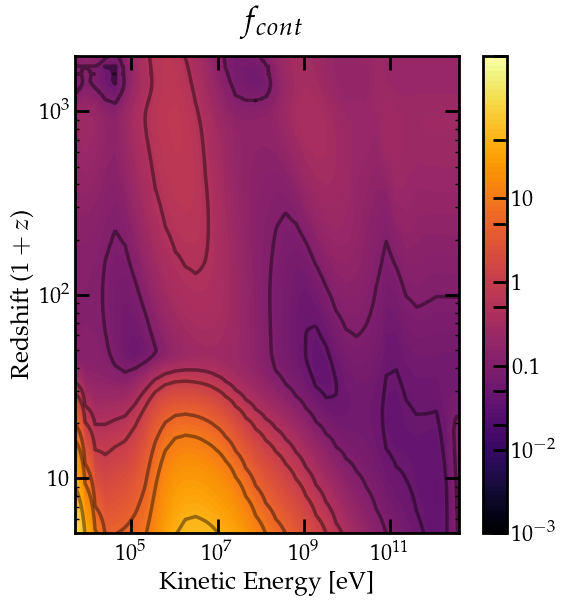

In [232]:
get_fcontour(f_DH_list2, inj_type, 'phot', 'cont')

In [70]:
def get_fdiff(inj_type, inj_particle, channel):
    folder = inj_str+'_'+inj_type+'/'
    f_DH_tmp = np.ones((40,round(6398/coarsen_factor)))*1e-6
#     for k in np.arange(40):
#         f_DH_tmp[k] = f_DH_data[k]['f']['low'][channel]
    
    eng = 10**log10eng   

    rs_list = np.array([3000*np.exp(-0.001*i) for i in np.arange(6398)])

    ind = {'H ion' : 0, 'He ion' : 1, 'exc' : 2, 'heat' : 3, 'cont' : 4}[channel]
    if ind < 2:
        label = {'H ion' : 'H_{ion}', 'He ion' : 'He_{ion}'}[channel]
    else:
        label = channel
    title = r'\bf{$f_{'+label+'}$}'
    f_DH_tmp = f_DH_list[:,ind,:]

    plt.figure()
    ax=plt.gca()
    ax.loglog()
    levels=[0,.01,.05,.1,.2,.3,.4,.5]#,.2,.3,.4,.5,1]
    
    diffs = np.zeros_like(f_DH_tmp)
    diffs = np.abs(
        f_DH_tmp - f_idl_list[:,ind]
    )/f_idl_list[:,ind]
    
    cs2 = ax.contourf(eng, rs_list, np.transpose(diffs), levels = levels,
                     cmap=matplotlib.cm.RdBu_r)
    cbar = plt.colorbar(cs2, ticks=levels)
    
    plt.title(title)
    plt.ylabel(r'Redshift ($1+z$)')
    plt.xlabel(r'Kinetic Energy [eV]')

    plt.savefig(
        '/Users/gregoryridgway/Desktop/4_14_DH_idl_comparisons/f'+inj_particle+'_'+inj_type+'_'+channel+'_IDLdiffs.png'
    )
    plt.show()

#     plt.savefig(
#         cwd+'/../../'+folder+'f'+inj_particle+'_'+inj_type+'_'+channel+'_IDLdiffs.png'
#     )

In [45]:
f_idl_list.shape

(40, 5, 6398)

In [46]:
f_DH_list.shape

(40, 5, 6398)

/usr/local/Cellar/ipython/7.2.0/libexec/vendor/lib/python3.7/site-packages/ipykernel_launcher.py:27: RuntimeWarning: divide by zero encountered in true_divide


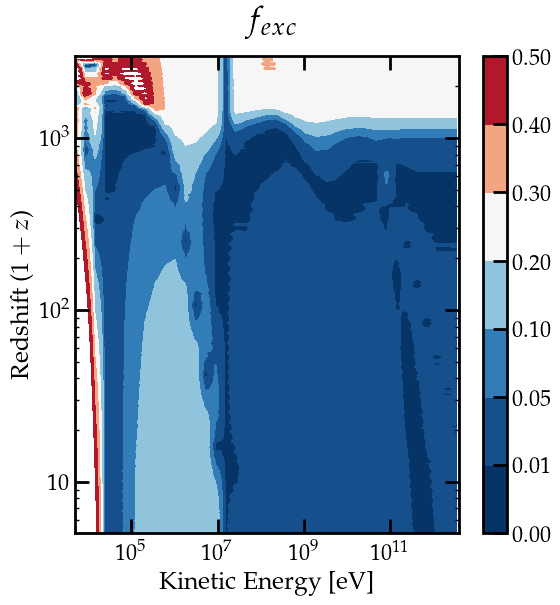

In [84]:
get_fdiff(inj_type, inj_str, 'exc')

/usr/local/Cellar/ipython/7.2.0/libexec/vendor/lib/python3.7/site-packages/ipykernel_launcher.py:27: RuntimeWarning: divide by zero encountered in true_divide


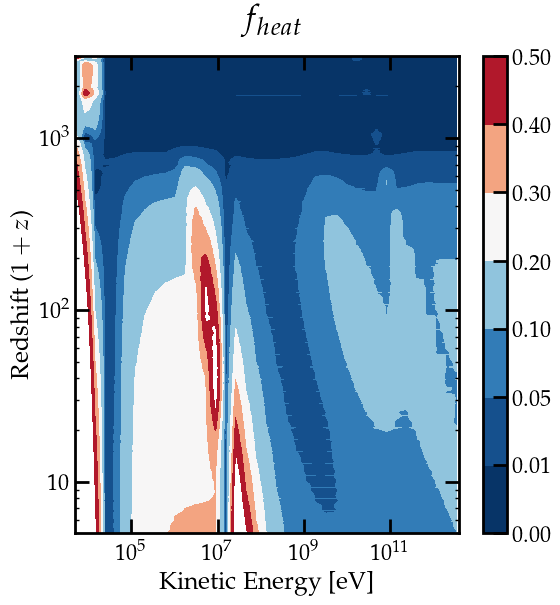

In [83]:
get_fdiff(inj_type, inj_str, 'heat')

/usr/local/Cellar/ipython/7.2.0/libexec/vendor/lib/python3.7/site-packages/ipykernel_launcher.py:27: RuntimeWarning: divide by zero encountered in true_divide


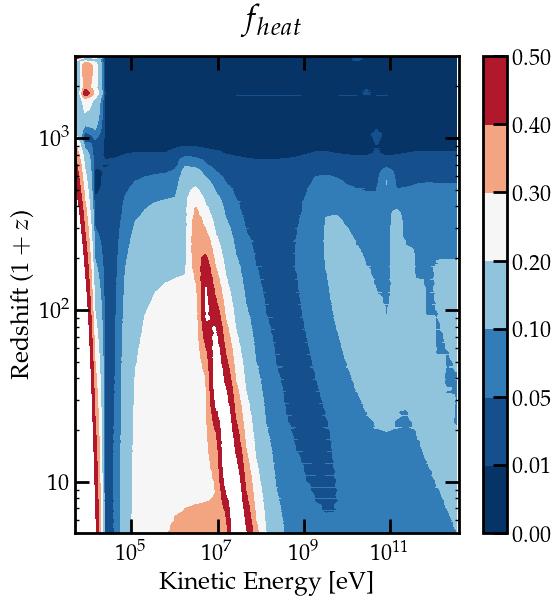

In [81]:
get_fdiff(inj_type, inj_str, 'heat')

/usr/local/Cellar/ipython/7.2.0/libexec/vendor/lib/python3.7/site-packages/ipykernel_launcher.py:27: RuntimeWarning: divide by zero encountered in true_divide


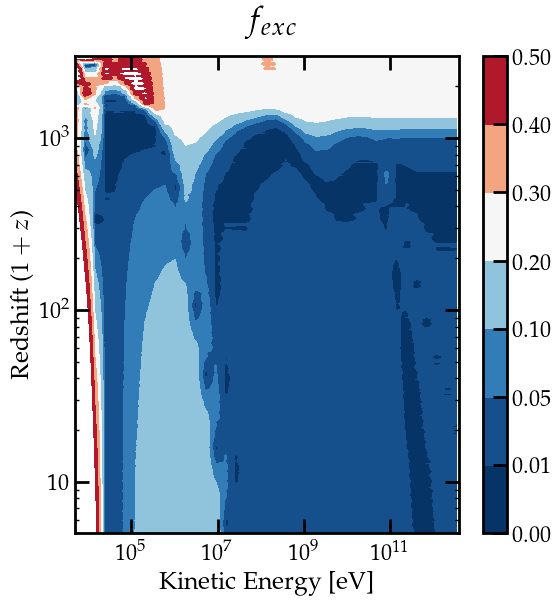

In [72]:
get_fdiff(inj_type, inj_str, 'exc')

/Users/gridgway/Desktop/DM/DarkHistory/examples/../../elec_decay/felec_decay_H_ion_IDLdiffs.png


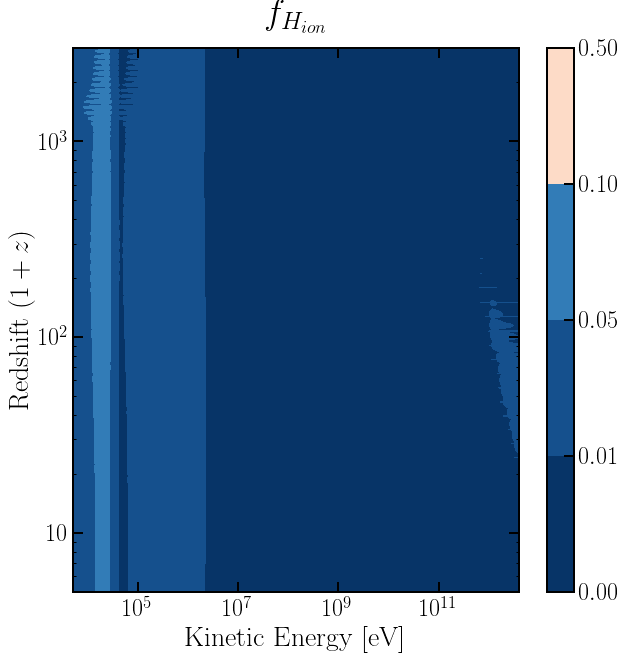

In [84]:
get_fdiff(inj_type, inj_str, 'H_ion')

In [75]:
inj_type

'decay'

In [78]:
log10eng[15]

7.186853929421996

In [79]:
get_column(15, f_DH_data, inj_particle=inj_particle, inj_type=inj_type, end_rs=4.004)

# Standard $f_c(z,E_\text{inj})$ grid values

In [253]:
inj_particle='photon'
inj_str=inj_particle[:4]
inj_type='swave'
strTmp=''
if inj_type == 'swave':
    strTmp = '_noStructure'
coarsen_factor = 2

In [254]:
f_DH_data = pickle.load(open('/Users/gridgway/Dropbox (MIT)/Photon Deposition/idl_comparison/GR_Checks/ih_continuous_'
                       +inj_str+'/f_'+inj_str+'_'+inj_type+'_notCrossCheck'+strTmp+'.p','rb')
                      )

In [240]:
f_DH_list = np.ones((40,5,round(6398/coarsen_factor)))*1e-6
for k in np.arange(40):
    f_DH_list[k] = np.array(
    [np.flipud(f_DH_data[k]['f']['low']['H ion']),
     np.flipud(f_DH_data[k]['f']['low']['He ion']),
     np.flipud(f_DH_data[k]['f']['low']['exc']),
     np.flipud(f_DH_data[k]['f']['low']['heat']),
     np.flipud(f_DH_data[k]['f']['low']['cont'])]
)
f_DH_list = np.swapaxes(f_DH_list, 1, 2)
f_DH_list[f_DH_list<=0] = 1e-12
pickle.dump(f_DH_list,open('/Users/gridgway/Dropbox (MIT)/Photon Deposition/DarkHistory_data/f_'+
                           inj_str+'_'+inj_type+'_std_.p','wb'))

In [249]:
f_DH_data[0]['rs'][9]

2946.4830970748976

In [247]:
f_DH_data[0]['f']['low']['cont'][9]

0.1267068385433199

Remember to:

    (1) Change back to DH parameters instead of IDL parameters (H0, etc.)
    (2) sum over partial bins (in the low energy electron methods)
    (3) off-by-one in the CMB subtraction

# SCRATCHWORK and NOTES

# Scratch

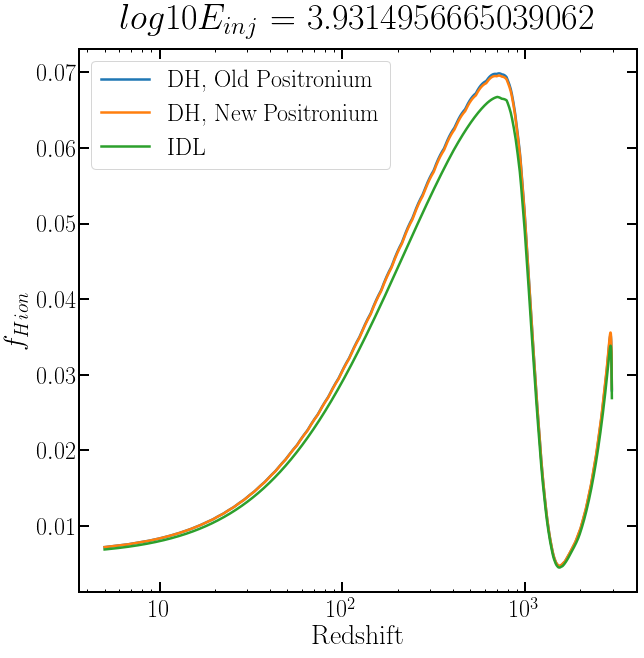

In [27]:
plt.figure()
ax = plt.gca()
ax.set_xscale('log')

Eind=1
ind=0

plt.title('$log10E_{inj}$ = '+str(log10eng[Eind]))
plt.plot(rs_list[10:-1], f_decay_elec[Eind,10:,ind], label='DH, Old Positronium')
plt.plot(rs_list[10:-1], data_elec[6][10:,ind], label='DH, New Positronium')
plt.plot(rs_list[10:-1], f_idl_list[Eind,ind,10:-1], label='IDL')

# plt.plot(rs_list[10:-1], (f_decay_elec[Eind,10:,ind]-f_idl_list[Eind,ind,10:-1])/f_idl_list[Eind,ind,10:-1], label='DH')

plt.ylabel(r'$f_{Hion}$')
plt.xlabel(r'Redshift')

plt.legend()

# plt.savefig('/home/gridgway/Desktop/fHion_discrepancy')

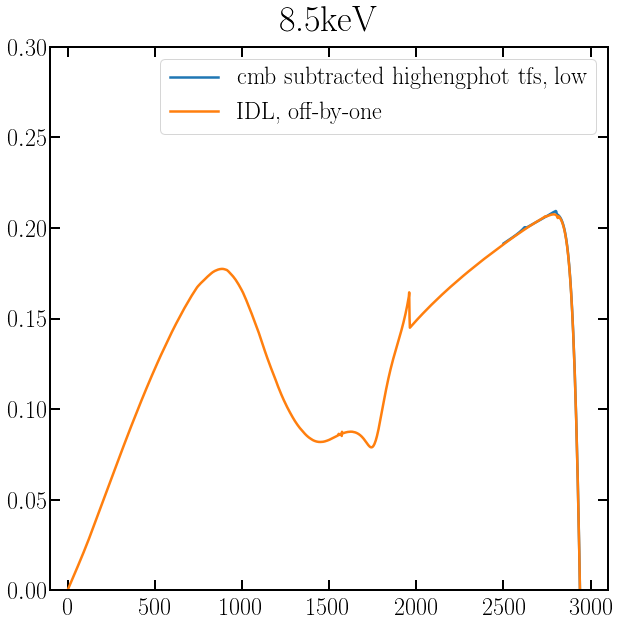

In [825]:
f_decay_phot0 = pickle.load(open("/home/gridgway/Dropbox (MIT)/Photon Deposition/f_decay_phot.p", "rb"))
rs_list = [3000*np.exp(-.001*i) for i in np.arange(6397)]

plt.figure()
ax=plt.gca()
# ax.loglog()
plt.axis([-100,3100,0,.3])
plt.title('8.5keV')


plt.plot(data_phot0[3].rs[:-1], data_phot0[6][0][:,4], label='cmb subtracted highengphot tfs, low')
# plt.plot(data_phot[3].rs[:-1], data_phot1[6][0][:,4], label='cmb subtracted lowengphot tfs, low')
# plt.plot(rs_list, f_decay_phot[1,:,4], label='cmb subtracted highengphot tfs')
# plt.plot(rs_list, f_decay_phot0[1,:,4], label='no cmb subtraction')
plt.plot(rs_list, f_idl_list[1,4,:-1], label='IDL, off-by-one')



# plt.plot(rs_list[10:], np.abs((f_idl_list[1,4,10:-1]-f_decay_phot[1,10:,4])/f_idl_list[1,4,10:-1]), label='IDL')
# plt.plot(rs_list[10:], np.abs((f_idl_list[1,4,10:-1]-f_decay_phot0[1,10:,4])/f_idl_list[1,4,10:-1]), label='IDL')

# plt.plot(data_phot[3].rs[:-1], data_phot[6][0][:,4]+data_phot[6][1][:,4], label='cmb subtracted highengphot tfs')

# plt.plot(idl_redshift[1:len(entries)+1], idl_flist[:,4], label='IDL, low')

# plt.plot(idl_redshift[:len(entries)], np.abs((idl_flist[:,4]-data_phot[6][0][:,4]-data_phot[6][1][:,4])/idl_flist[:,4]), label='IDL')

plt.legend()

# plt.savefig(
#     '/home/gridgway/Desktop/f_cont_offbyone_error.png'
# )

In [775]:
%autoreload
#fs from idl run
from darkhistory.low_energy.lowE_electrons import make_interpolator
from darkhistory.low_energy import lowE_deposition as lowE_dep
MEDEA_interp = make_interpolator()

E_tmp=10**log10eng[1]
entries=np.arange(4000)+1

idl_flist = [
    lowE_dep.compute_fs(
        MEDEA_interp,
        phot_spec=Spectrum(idl_energy, phot, rs=rs),
        elec_spec=Spectrum(idl_eleceng, elec*0, rs=rs),
        x = np.array([1-xe, 0, 0]),
        dt = .001/hub,
#         highengdep = highdep_interps.get_val(xe, rs)[indTmp],
        highengdep = highdeposited*np.array([1,1,1,0]),
        cmbloss = loss * hub/phys.hubble(rs*np.exp(.002)), #THIS factor of dt(z+2dz)/dt(z) compensates for IDL's off-by-one error
#         dE_dVdt_inj = phys.inj_rate('decay', rs, mDM=E_tmp, tau=tau)*2
        dE_dVdt_inj = 2*E_tmp*rate*phys.nB*rs**3
    )
    for xe, rs, phot, elec, loss, hub, rate, highdeposited in zip(data.field('hionfraction')[0][entries], 
                                   idl_redshift[entries],                            
                                   idl_lowengphot[entries],
                                   idl_lowengelec[entries],
                                   idl_cmblosstable[entries-1],
                                   data.field('hubblerate')[0][entries],
                                   data.field('annrate')[0][entries],
                                   np.transpose(idl_highengdep[:,entries]))]

idl_flist=np.array(idl_flist)

In [142]:
import multiprocessing  # the module we will be using for multiprocessing

def work(number):
    """
    Multiprocessing work
    
    Parameters
    ----------
    number : integer
        unit of work number
    """
    
    print("Unit of work number %d" % number)  # simply print the worker's number
    
def nonsense():
    print("There are %d CPUs on this machine" % multiprocessing.cpu_count())
    number_processes = 1
    pool = multiprocessing.Pool(number_processes)
    total_tasks = 4
    tasks = range(total_tasks)
    results = pool.map_async(get_column, tasks)
    print(results)
    pool.close()
    pool.join()

In [142]:
import multiprocessing  # the module we will be using for multiprocessing

def work(number):
    """
    Multiprocessing work
    
    Parameters
    ----------
    number : integer
        unit of work number
    """
    
    print("Unit of work number %d" % number)  # simply print the worker's number
    
def nonsense():
    print("There are %d CPUs on this machine" % multiprocessing.cpu_count())
    number_processes = 1
    pool = multiprocessing.Pool(number_processes)
    total_tasks = 4
    tasks = range(total_tasks)
    results = pool.map_async(get_column, tasks)
    print(results)
    pool.close()
    pool.join()

In [142]:
import multiprocessing  # the module we will be using for multiprocessing

def work(number):
    """
    Multiprocessing work
    
    Parameters
    ----------
    number : integer
        unit of work number
    """
    
    print("Unit of work number %d" % number)  # simply print the worker's number
    
def nonsense():
    print("There are %d CPUs on this machine" % multiprocessing.cpu_count())
    number_processes = 1
    pool = multiprocessing.Pool(number_processes)
    total_tasks = 4
    tasks = range(total_tasks)
    results = pool.map_async(get_column, tasks)
    print(results)
    pool.close()
    pool.join()

In [4]:
def get_fcontour(inj_type, inj_particle, channel):
    if inj_particle is 'elec':
        coarsen_factor = 16

        if inj_type is 'decay':
            f_for_plot = f_decay_elec.copy()
            folder='elec_decay/'

        elif inj_type is 'swave':
            f_for_plot = f_swave_elec.copy()
            folder='elec_swave/'
    else:
        coarsen_factor = 8

        if inj_type is 'decay':
            f_for_plot = f_decay_phot.copy()
            folder='phot_decay/'

        elif inj_type is 'swave':
            f_for_plot = f_swave_phot.copy()
            folder='phot_swave/'
    
    eng = 10**log10eng[:len(f_for_plot)]
    rs_list = [3000*np.exp(-0.001*coarsen_factor*(i)) for i in np.arange(6400/coarsen_factor)]

    if channel is 'H_ion':
        ind=0
        title = r'\bf{$f_{H ion}$}'
    elif channel is 'He_ion':
        ind=1
        title = r'\bf{$f_{He ion}$}'
    elif channel is 'exc':
        ind=2
        title = r'\bf{$f_{exc}$}'
    elif channel is 'heat':
        ind=3
        title = r'\bf{$f_{heat}$}'
    elif channel is 'cont':
        ind=4
        title = r'\bf{$f_{cont}$}'

    ax = plt.gca()
    ax.set_xscale('log')
    ax.set_yscale('log')

    plt.axis([eng[0], 10**log10eng[-1], 5, 2e3])

    levels = np.array([1e-5, 1e-4, 1e-3, 5e-3, 1e-2, 5e-2, 1e-1, 3e-1, 1e0])
    if inj_type is 'decay':
        if channel is 'He_ion':
            if inj_particle is 'phot':
                levels = np.array([1e-7, 1e-6, 1e-5, 1e-4, 5e-4, 1e-3, 5e-3, 1e-2, 4e-2])
            else:
                levels = np.array([1e-6, 1e-5, 5e-5, 1e-4, 5e-4, 1e-3, 5e-3, 1e-2, 4e-2])
        elif channel is 'exc':
            if inj_particle is 'phot':
                levels = np.array([1e-5, 1e-4, 1e-3, 5e-3, 1e-2, 3e-2, 5e-2, 1e-1, 1e-0])
            else:
                levels = np.array([1e-4, 1e-3, 5e-3, 1e-2, 3e-2, 5e-2, 1e-1, 2e-1, 7e-1])
        elif (channel is 'heat') or (channel is 'cont'):
            if inj_particle is 'elec':
                levels = np.array([1e-5, 1e-4, 1e-3, 1e-2, 5e-2, 1e-1, 3e-1, 5e-1, 1, 2])
    elif inj_type is 'swave':
        if channel is 'H_ion':
            if inj_particle is 'phot':
                levels = np.array([1e-3, 1e-2, 1e-1, 2e-1, 5e-1, 1, 5, 1e1, 5e1, 1e2])
        elif channel is 'He_ion':
            if inj_particle is 'phot':
                levels = np.array([5e-5, 1e-4, 1e-3, 5e-3, 1e-2, 5e-2, 1e-1, 5e-1, 2])
        elif channel is 'exc':
            if inj_particle is 'phot':
                levels = np.array([5e-3, 1e-2, 5e-2, 1e-1, 5e-1, 1, 5, 1e1, 1e2, 3e2])
        elif channel is 'heat':
            if inj_particle is 'phot':
                levels = np.array([1e-3, 1e-2, 2e-2, 5e-2, 1e-1, 2e-1, 5e-1, 1, 5, 1e1, 3e1])
        elif channel is 'cont':
            if inj_particle is 'phot':
                levels = np.array([1e-3, 1e-2, 2e-2, 5e-2, 1e-1, 5e-1, 1, 5, 1e1, 5e1, 1e2])

                
    f_for_plot[f_for_plot < levels[0]] = levels[0]*(1+.01)
    f_for_plot[f_for_plot > levels[-1]] = levels[-1]*(1-.01)
    
    levels2 = np.exp(np.linspace(np.log(levels[0]),np.log(levels[-1]),100))
    cs = ax.contourf(eng,rs_list,
                     np.transpose(f_for_plot[:,:,ind]), 
#                      locator=matplotlib.ticker.LogLocator(), 
                     norm=matplotlib.colors.LogNorm(),
                     levels=levels2,
                     cmap=matplotlib.cm.RdBu_r)
    ax.contour(eng,rs_list,
               np.transpose(f_for_plot[:,:,ind]),  
               levels=levels[1:-1],
               colors='k',
               alpha=.4
              )

    cbar = plt.colorbar(cs, ticks=levels)
    cbar.ax.set_xticklabels(str(levels))

    plt.title(title)
    plt.ylabel(r'Redshift ($1+z$)')
    plt.xlabel(r'Kinetic Energy [eV]')

#     direc = '/Users/GregoryRidgway/Desktop/Dark Matter/DH_Data/'
#     plt.savefig(
#         direc+'f'+inj_particle+'_'+inj_type+'_'+channel+'_contour.pdf'
#     )

### Structure Formation

In [ ]:
if inj_type == 'decay':
    def struct_boost(rs):
        return 1
else:
    struct_data = np.loadtxt(open(cwd+"/../structure_formation_data/boost_Einasto_subs.txt", "rb"))
    log_struct_interp = interp1d(np.log(struct_data[:,0]), np.log(struct_data[:,1]))
    def struct_boost(rs):
        if rs<76:
            return np.exp(log_struct_interp(np.log(rs)))
        else:
            return 1

# electon troubleshooting

In [157]:
Eind = 3
Elabel = float_formatter(np.log10(10**log10eng[Eind]+mass),3)

In [158]:
direc = cwd+'/../../ih_continuous_'+inj_str

hdul = fits.open(
    direc+'/IDL_runs/'
    +'tf_z_3.000E+03_nstep_6398_logE_'+Elabel+'_xe_0.000E+00.fits'
)
    
data = hdul[1].data

idl_photonspectrum = data.field('photonspectrum')[0]
idl_lowengphot = data.field('lowengphot')[0]
idl_lowengelec = data.field('lowengelec')[0]
idl_energy = data.field('energy')[0]
idl_eleceng = data.field('eleceng')[0]
idl_redshift = data.field('redshift')[0]
idl_cmblosstable = data.field('cmblosstable')[0]
idl_highengdep = data.field('highdeposited_grid')[0]

idl_bin_width = np.diff(np.log(spectools.get_bin_bound(data.field('energy')[0]))) * idl_energy
idl_elec_bin_width = np.diff(np.log(spectools.get_bin_bound(data.field('eleceng')[0]))) * idl_eleceng

xe_idl = data.field('hionfraction')[0]
xHe_idl = data.field('heionfraction')[0]

hdul.close()

xe_idl_func = interp1d(idl_redshift, xe_idl, bounds_error=False, fill_value=(xe_idl[-1], xe_idl[0]))
xHe_idl_func = interp1d(idl_redshift, xHe_idl, bounds_error=False, fill_value=(xHe_idl[-1], xHe_idl[0]))

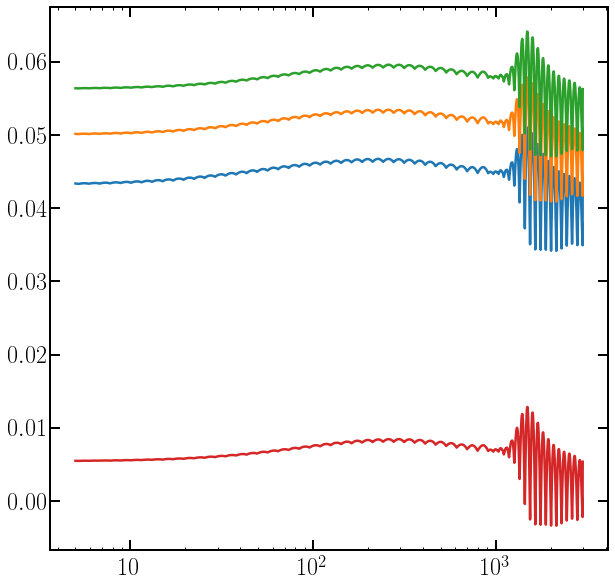

In [90]:
rs_list = np.array([3000*np.exp(-0.001*i) for i in np.arange(6398)])

tmp=3
ind=0
diffs = f_DH_list[:,0,:,ind]/f_idl_list[:,ind] - 1

plt.figure()
ax = plt.gca()
ax.set_xscale('log')
plt.plot(rs_list, diffs[tmp-2])
plt.plot(rs_list, diffs[tmp-1])
plt.plot(rs_list, diffs[tmp])
plt.plot(rs_list, diffs[tmp+1])

rs:  3.0E+03


/Users/gridgway/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:22: RuntimeWarning: invalid value encountered in true_divide


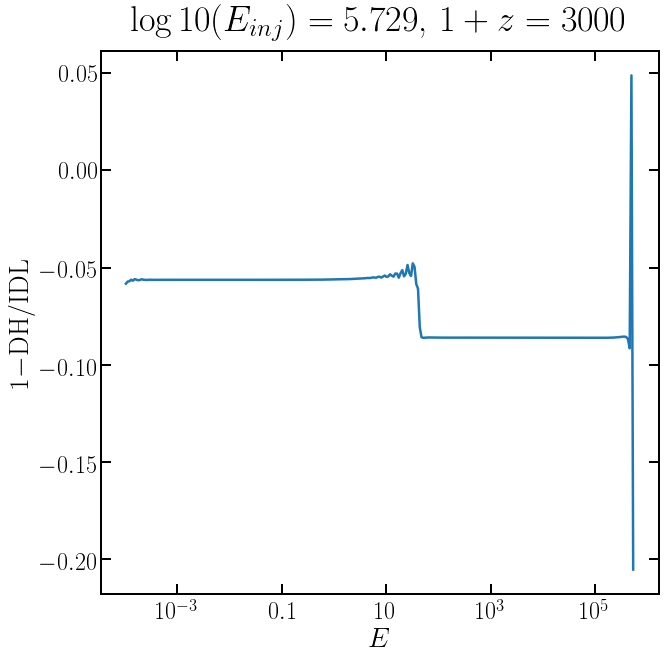

In [170]:
rsInd = 0
rsLabel = float_formatter(idl_redshift[rsInd], 1)
print("rs: ", rsLabel)

# EInd = len(photeng[photeng<Einj])
idl_spec = Spectrum(idl_energy,idl_photonspectrum[rsInd], spec_type='dNdE')
plt.figure()
ax = plt.gca()

# ax.loglog()
# ax.set_xlabel('$E$')
# ax.set_ylabel('$dN/dE$')
# plt.title('High Energy Photons, $1+z=$'+rsLabel[:1]+', $\log 10(E_{inj}) = '+Elabel[:5]+'$')
# plt.plot(photeng, idl_spec.N, label='IDL')
# plt.plot(photeng, f_DH_data[Eind][2]._grid_vals[rsInd], label='DH')
# plt.legend()

ax.set_xscale('log')
ax.set_xlabel('$E$')
ax.set_ylabel('$1-$DH/IDL')
plt.title('$\log 10(E_{inj}) = '+Elabel[:5]+'$, $1+z=3000$')
plt.plot(photeng, 1-f_DH_data[Eind][2]._grid_vals[rsInd]/idl_spec.N)

# plt.savefig(
#     cwd+'/../../../elec_dNdE_log10E_'+Elabel[:5]+'_rs3000.png'
# )
# plt.savefig(
#     cwd+'/../../../elec_dNdE_log10E_10.607_rs3000.png'
# )

# Homework

In [38]:
from scipy.integrate import odeint

In [82]:
def func(s, var):
    V, th, M = var[0], var[1], var[2]
    return np.array([
        -2*V/s + (-72*2**(2/3)*np.pi*(1+th**(2/3))**(5/2)*th**(7/3) + 
                V**2*(5+16*th**(2/3)+8*th**(4/3)))/(
            3*(1+th**(2/3))*(5+4*th**(2/3))*th
        ),
        V,
        th*s**2
    ])

In [199]:
thcList = 10**(np.arange(4,12.5,.5))
finList = [7e-2,6e-2,4e-2,3e-2,2e-2,1.2e-2,1e-2]

In [218]:
ind = 16
init=1e-6
final=2e-4#finList[ind]
hmax=1e-7
m=1e3
thc = thcList[ind]

init_cond = np.array([0, thc, 0])
s_vec = np.array([init + (final-init)/m*i for i in np.arange(m)])

soln = odeint(func, init_cond, s_vec, tfirst=True, hmax=hmax#, rtol=rtol
            )

In [219]:
soln[-1,1]/thc

1.9829509985590903e-05

In [220]:
soln[-1]

array([-3.51822914e+12,  1.98295100e+07,  6.40701164e-02])

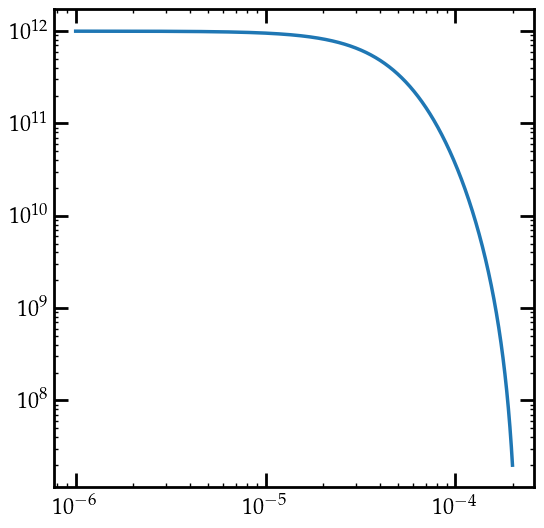

In [221]:
plt.figure()
ax=plt.gca()
ax.loglog()
plt.plot(s_vec, soln[:,1])
plt.show()

# Scratch

In [140]:
tmpList = [None,None]

In [102]:
log10eng[2]

4.164021259421997

In [145]:
goods = [tmpList[0]['f'], tmpList[1]['f']]

In [142]:
def get_column(i, f_DH_list, inj_particle='photon', inj_type='swave', end_rs=4.004):
    """ Produce one column of the f differential plot
    """
    #injection energy, DM mass, center-of-mass energy
    if i == 0:
        Einj = 10**log10eng[2]
    else:
        Einj = 10**log10eng[-4]
    
    
    mDM = 2*Einj + 2*phys.me*0
    Ecom=mDM
    
    struct_boost = phys.struct_boost_func('einasto_with_subs')
    
    def rate_func_N(rs):
        return phys.inj_rate(inj_type, rs, mDM=mDM, sigmav=sigmav, tau=tau)*struct_boost(rs)/Ecom
    def rate_func_eng(rs):
        return phys.inj_rate(inj_type, rs, mDM=mDM, sigmav=sigmav, tau=tau)*struct_boost(rs)
    
    if inj_type == 'swave':
        mDM = mDM/2
        Ecom = 2*mDM   
    

    primary = 'phot_delta'
    
    f_DH_list[i] = main.evolve(
        primary=primary,
        rate_func_N=rate_func_N, rate_func_eng=rate_func_eng,
        DM_process=inj_type, mDM=mDM, sigmav=sigmav, lifetime=tau,
        start_rs = 3000, end_rs=end_rs,
        coarsen_factor=4, backreaction=False,
        struct_boost=struct_boost
    )

In [143]:
get_column(0, tmpList, inj_particle='photon', inj_type='swave', end_rs=4.004)

/usr/local/lib/python3.7/site-packages/scipy/integrate/odepack.py:247: ODEintWarning: Excess work done on this call (perhaps wrong Dfun type). Run with full_output = 1 to get quantitative information.
  warnings.warn(warning_msg, ODEintWarning)
../darkhistory/physics.py:474: RuntimeWarning: invalid value encountered in double_scalars
  / (1 + 0.6703 * (conv_fac*T_m)**0.5300)


-3.4805041800627565
-3.8131374110827236
-4.186359487653335
-4.504861037894029
-3.8584844657896893
-4.227893347075622
-3.9799221376989142
-3.5665378601456275
-3.194310205712982
-2.8588518613608245
-2.5304331238662305
-2.1580711281115788
-2.1136155680196556
-1.6965374119028538
-1.3856510684382684
-1.0733787048415597
-0.32318284546923715
-0.17919661466676612
-0.6154172364908335
-0.006747489663369688



In [144]:
get_column(1, tmpList, inj_particle='photon', inj_type='swave', end_rs=4.004)

In [110]:
pickle.dump(goods,open('/Users/gregoryridgway/Dropbox (MIT)/Photon Deposition/cross_checks/elec_swave_log10E_4p16_12p1.p','wb'))

In [147]:
inj_str = 'phot'
inj_type = 'swave'
f_DH_data_swave = pickle.load(open(
            '/Users/gregoryridgway/Dropbox (MIT)/Photon Deposition/idl_comparison/GR_Checks/ih_continuous_'
                       +inj_str+'/f_'+inj_str+'_'+inj_type+'_notCrossCheck.p','rb')
                      )

In [113]:
tmpList[0]['rs'] - 3000*np.exp(-.012*np.arange(552))

array([ 0.00000000e+00, -9.09494702e-13,  0.00000000e+00,  1.36424205e-12,
        2.72848411e-12,  4.09272616e-12,  5.00222086e-12,  6.36646291e-12,
        7.27595761e-12,  8.18545232e-12,  9.54969437e-12,  1.04591891e-11,
        1.13686838e-11,  1.22781785e-11,  1.36424205e-11,  1.40971679e-11,
        1.54614099e-11,  1.59161573e-11,  1.68256520e-11,  1.72803993e-11,
        1.86446414e-11,  1.95541361e-11,  2.00088834e-11,  2.09183781e-11,
        2.18278728e-11,  2.22826202e-11,  2.27373675e-11,  2.36468622e-11,
        2.45563569e-11,  2.45563569e-11,  2.54658516e-11,  2.63753464e-11,
        2.68300937e-11,  2.75122147e-11,  2.77395884e-11,  2.84217094e-11,
        2.86490831e-11,  2.95585778e-11,  3.00133252e-11,  3.02406988e-11,
        3.06954462e-11,  3.09228199e-11,  3.16049409e-11,  3.20596882e-11,
        3.25144356e-11,  3.27418093e-11,  3.31965566e-11,  3.34239303e-11,
        3.38786776e-11,  3.41060513e-11,  3.41060513e-11,  3.45607987e-11,
        3.47881723e-11,  

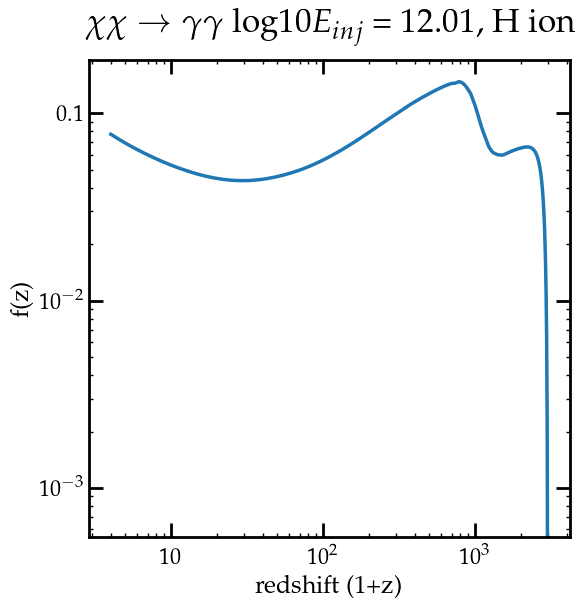

In [165]:
plt.figure()
rs_vec = 3000*np.exp(-.004*np.arange(1655))
ax = plt.gca()
ax.loglog()
ind = 1

string = 'H ion'

label='12.01'

plt.xlabel('redshift (1+z)')
# plt.ylabel('[with cross checks] / [w/o] - 1')
plt.ylabel('f(z)')
plt.title(r'$\chi\chi \to \gamma \gamma$ log10$E_{inj}$ = '+label+', '+string)
plt.plot(rs_vec, f_DH_data_swave[2-ind*6]['f']['low'][string][::4])
# plt.plot(rs_vec, f_DH_data_swave[2-ind*6]['f']['low'][string][::4]/tmpList[ind]['f']['low'][string]-1)
plt.savefig('/Users/gregoryridgway/Desktop/4_14_DH_idl_comparisons/phot_swave_Hion_log10E_12p01.png')
# plt.savefig('/Users/gregoryridgway/Desktop/4_14_DH_idl_comparisons/phot_swave_compare_log10E_12p01_Hion.png')

In [ ]:
data = pickle.load(open('/Users/hongwan/Dropbox (MIT)/Photon Deposition/cross_checks/elec_swave_log10E_4p16_12p1.p','rb'))